In [8]:
# !wget "https://live.staticflickr.com/3668/12541513325_28207937e0_o_d.jpg" -O image.jpeg
!wget "https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731" -O image.jpeg

--2025-03-25 17:35:10--  https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731
Resolving service.archief.nl (service.archief.nl)... 195.169.53.74, 2001:610:1e0::2:adf:ff4a
Connecting to service.archief.nl (service.archief.nl)|195.169.53.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg              [      <=>           ]   1.16M   778KB/s    in 1.5s    

2025-03-25 17:35:13 (778 KB/s) - ‘image.jpeg’ saved [1219191]



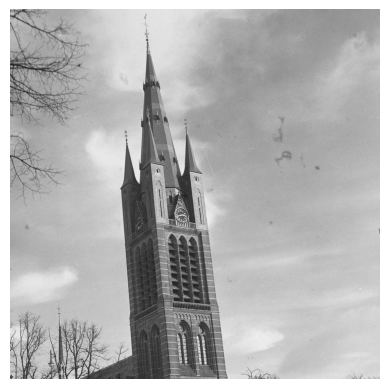

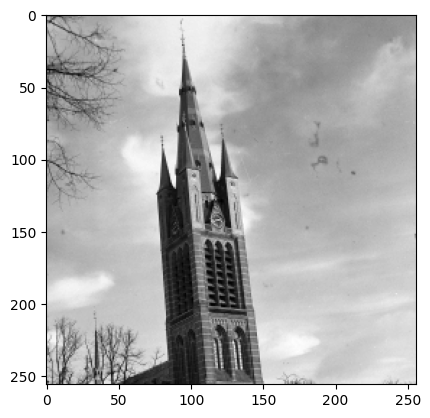

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('image.jpeg', cv2.IMREAD_GRAYSCALE)

# Define cropping coordinates
x, y, w, h = 700, 220, 2048, 2048
img = img[y:y+h, x:x+w]

# Show cropped image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Resize image to 256x256
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

# Show resized image
plt.imshow(img, cmap='gray')
plt.show()

original_img = img.copy()

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def deconvolve_image(img, sigma_t=2):
    # Define input x and kernel k
    x = img
    sigma = 2
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**1) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
    ]) / (2 * np.pi * sigma**2)

    k /= k.sum()

    # Convolution with 'full' mode
    y = convolve2d(x, k, mode='full')

    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**1) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 0**2) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**2) / (2 * sigma_t**2)) )]
    ]) / (2 * np.pi * sigma_t**2)

    k /= k.sum()

    # FFT size (use y's shape to ensure proper padding)
    fft_shape = y.shape

    # Compute FFTs
    y_fft = np.fft.fft2(y, fft_shape)
    k_fft = np.fft.fft2(k, fft_shape)

    # Unregularized deconvolution
    x_recovered = np.fft.ifft2(y_fft / k_fft).real

    # Regularized deconvolution
    # eps = 1e-8
    # x_recovered_fft = (y_fft * np.conj(k_fft)) / (np.abs(k_fft) ** 2 + eps)
    # x_recovered = np.fft.ifft2(x_recovered_fft).real


    # Extract the **valid** region (top-left alignment)
    valid_shape = x.shape
    x_recovered = x_recovered[:valid_shape[0], :valid_shape[1]]

    # Compute MSE, PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    # Print results
    print("Original x:\n", x)
    print("\nRecovered x from frequency domain:\n", np.round(x_recovered))
    print("\nMSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Plot images
    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(np.round(x_recovered), cmap='gray'), plt.title("Recovered Image")
    plt.show()

    return x_recovered, mse_recovery, psnr_recovery


sigmas = [1.6, 1.7, 1.8, 1.9, 2.01, 2.2, 2.4, 2.6, 2.8]
results = []

for sigma in sigmas:
    X_recovered, mse, psnr = deconvolve_image(img, sigma_t=sigma)
    results.append((X_recovered, mse, psnr))


for i, (X_recovered, mse, psnr) in enumerate(results):
    print(f"Results for sigma={sigmas[i]}:")
    print("Recovered x from frequency domain:", np.round(X_recovered))
    print("MSE between original and recovered x:", mse)
    print("PSNR between original and recovered x:", psnr)
    print("-------")

# plot all the recovered images and sigma values

plt.figure(figsize=(35, 5))
for i, (X_recovered, mse, psnr) in enumerate(results):
    plt.subplot(1, len(results), i + 1)  # Create subplots in a single row
    plt.imshow(X_recovered, cmap='gray')
    plt.title(f"Recovered Image (sigma={sigmas[i]})")

plt.show()  # Show all subplots together


Output hidden; open in https://colab.research.google.com to view.

y shape:  (256, 256)
Recovered x from frequency domain: [[134. 151. 106. ... 118.  83.  92.]
 [166. 195. 140. ... 155. 106. 112.]
 [133. 152.  98. ... 127.  83.  89.]
 ...
 [ 84. 166. 147. ... 206. 107.  54.]
 [ 58. 111.  90. ... 128.  65.  35.]
 [ 76. 103.  78. ...  95.  56.  49.]]
MSE between original and recovered x: 553.4749533267038
PSNR between original and recovered x: -12.24584032440514
-------


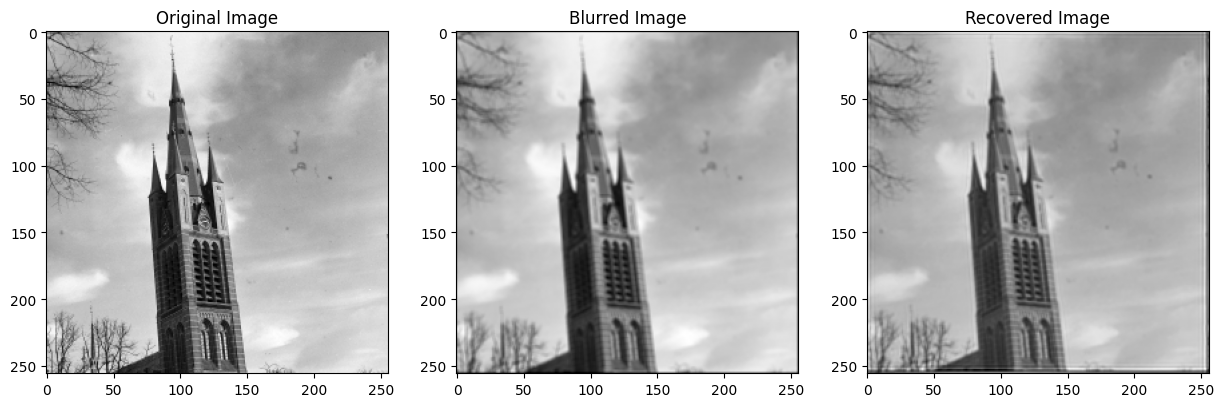

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def deconvolve_image(x, y, eps=0.1, sigma_t=2):

    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**1) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 0**2) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**2) / (2 * sigma_t**2)) )]
    ]) / (2 * np.pi * sigma_t**2)

    k /= k.sum()

    # FFT size (use y's shape to ensure proper padding)
    fft_shape = y.shape

    # Compute FFTs
    y_fft = np.fft.fft2(y, fft_shape)
    k_fft = np.fft.fft2(k, fft_shape)

    # Unregularized deconvolution
    # x_recovered = np.fft.ifft2(y_fft / k_fft).real

    # Regularized deconvolution
    # eps = 0.0
    x_recovered_fft = (y_fft * np.conj(k_fft)) / (np.abs(k_fft) ** 2 + eps)
    x_recovered = np.fft.ifft2(x_recovered_fft).real


    # Extract the **valid** region (top-left alignment)
    valid_shape = x.shape
    x_recovered = x_recovered[:valid_shape[0], :valid_shape[1]]

    # Compute MSE, PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    return x_recovered, mse_recovery, psnr_recovery

# Define input x and kernel k
x = img
sigma = 2
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**1) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)

k /= k.sum()

# Convolution with 'full' mode
y = convolve2d(x, k, mode='full')
y = convolve2d(x, k, mode='same')
print("y shape: ", y.shape)

X_recovered, mse, psnr = deconvolve_image(x, y, eps=0.1, sigma_t=2)

print("Recovered x from frequency domain:", np.round(X_recovered))
print("MSE between original and recovered x:", mse)
print("PSNR between original and recovered x:", psnr)
print("-------")

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
plt.subplot(133), plt.imshow(np.round(X_recovered), cmap='gray'), plt.title("Recovered Image")
plt.show()


Optimal epsilon: 1e-06
Best PSNR: -12.24584032440514


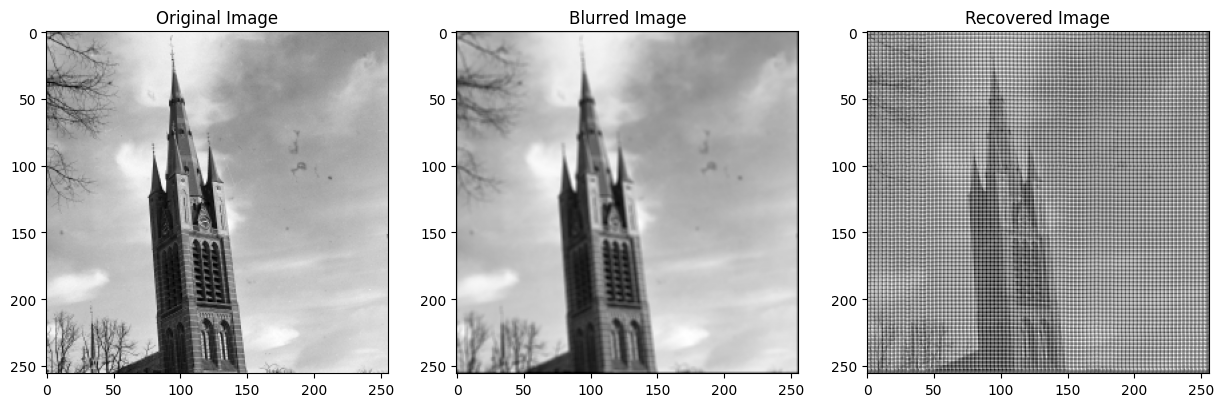

In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def deconvolve_image(x, y, eps, sigma_t=2):
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**2) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 0**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 0**2) / (2 * sigma_t**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((0**2 + 1**2) / (2 * sigma_t**2))), np.exp(-((1**2 + 1**2) / (2 * sigma_t**2)))]
    ]) / (2 * np.pi * sigma_t**2)
    k /= k.sum()

    fft_shape = y.shape
    y_fft = np.fft.fft2(y, fft_shape)
    k_fft = np.fft.fft2(k, fft_shape)

    x_recovered_fft = (y_fft * np.conj(k_fft)) / (np.abs(k_fft) ** 2 + eps)
    x_recovered = np.fft.ifft2(x_recovered_fft).real
    x_recovered = x_recovered[:x.shape[0], :x.shape[1]]

    mse = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr = 10 * np.log10(max_val**2 / mse)

    return x_recovered, mse, psnr

def optimize_epsilon(x, y, init_eps=0.1, lr=0.01, max_iters=1000, tol=1e-6):
    eps = init_eps
    best_eps = eps
    best_psnr = -np.inf

    for _ in range(max_iters):
        _, _, psnr = deconvolve_image(x, y, eps)
        grad = (deconvolve_image(x, y, eps + 1e-5)[2] - psnr) / 1e-5  # Numerical gradient
        eps += lr * grad  # Update step
        eps = max(1e-6, eps)  # Ensure epsilon stays positive

        if psnr > best_psnr:
            best_psnr = psnr
            best_eps = eps

        if abs(grad) < tol:
            break

    return best_eps, best_psnr

# Load input image
x = img  # Assuming 'img' is already defined
sigma = 2
k = np.array([
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
    [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
]) / (2 * np.pi * sigma**2)
k /= k.sum()

y = convolve2d(x, k, mode='same')

best_eps, best_psnr = optimize_epsilon(x, y)
X_recovered, mse, psnr = deconvolve_image(x, y, best_eps)

print(f"Optimal epsilon: {best_eps}")
print(f"Best PSNR: {best_psnr}")

plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
plt.subplot(133), plt.imshow(np.round(X_recovered), cmap='gray'), plt.title("Recovered Image")
plt.show()


In [ ]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt


def compute_image_gradient(img):
    # Define Sobel kernels
    Sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])  # Horizontal gradient kernel
    Sy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])  # Vertical gradient kernel

    # Compute gradient components
    Gx = convolve2d(img, Sx, mode='same', boundary='symm')
    Gy = convolve2d(img, Sy, mode='same', boundary='symm')

    # Compute gradient magnitude
    G = np.sqrt(Gx**2 + Gy**2)

    return G

def compute_image_laplacian(img):
    # Define Laplacian kernel
    L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Compute Laplacian
    L = convolve2d(img, L, mode='same', boundary='symm')

    return L


sigmas = [1.6, 1.7, 1.8, 1.9, 1.96, 1.98, 2.00, 2.01, 2.04, 2.08, 2.2, 10.8, 20.2, 40.3]
results = []

for sigma in sigmas:
    X_recovered, mse, psnr = deconvolve_image(img, sigma_t=sigma)
    results.append((X_recovered, mse, psnr))


for i, (X_recovered, mse, psnr) in enumerate(results):
    print(f"Results for sigma={sigmas[i]}:")
    print("Recovered x from frequency domain:", np.round(X_recovered))
    print("MSE between original and recovered x:", mse)
    print("PSNR between original and recovered x:", psnr)
    print("-------")

# plot all the recovered images and sigma values

plt.figure(figsize=(70, 10))
for i, (X_recovered, mse, psnr) in enumerate(results):
    plt.subplot(2, len(results), i + 1)  # Create subplots in a single row
    plt.imshow(X_recovered, cmap='gray')
    plt.title(f"Recovered Image (sigma={sigmas[i]})")

    plt.subplot(2, len(results), i + len(results) + 1)  # Create subplots in a single row
    lap = compute_image_laplacian(X_recovered)
    lap_norm = (lap - lap.min()) / (lap.max() - lap.min())
    lap_binary = (lap_norm < 0.5).astype(float)
    lap_count = np.sum(lap_binary)
    plt.imshow(lap_binary, cmap='binary')
    plt.title(f"Laplacian (sigma={sigmas[i]}), bpixel: {lap_count}")

plt.show()  # Show all subplots together




Output hidden; open in https://colab.research.google.com to view.

In [16]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=50):
    """
    Perform Richardson-Lucy blind deconvolution to estimate both x and k.

    Parameters:
    y : np.array
        Blurred image
    k_init : np.array
        Initial guess for the blur kernel
    num_iter : int
        Number of iterations to run

    Returns:
    x_est : np.array
        Estimated sharp image
    k_est : np.array
        Estimated blur kernel
    """

    x_est = np.copy(y)  # Initialize x as y
    k_est = np.copy(k_init)  # Initial kernel guess

    for i in range(num_iter):
        # Compute blurred estimate of x
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_x = y / (x_blurred + 1e-8)
        x_est *= convolve2d(relative_blur_x, k_est[::-1, ::-1], mode='same', boundary='wrap')

        # Compute blurred estimate of k
        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_k = y / (k_blurred + 1e-8)
        k_update = convolve2d(x_est[::-1, ::-1], relative_blur_k, mode='valid', boundary='wrap')

        # Normalize the kernel to sum to 1
        k_est *= k_update
        k_est /= np.sum(k_est)

    return x_est, k_est

def evaluate(num_iter):
    # Define Gaussian blur kernel
    sigma = 5
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
    ]) / (2 * np.pi * sigma**2)
    k /= k.sum()

    # Load an example image (grayscale 256x256)
    x = img  # Assuming 'img' is a 256x256 image

    # Generate blurred image
    y = convolve2d(x, k, mode='same', boundary='wrap')

    # Initialize the kernel estimate
    # k_init = np.ones_like(k) / np.sum(k)
    k_init = np.abs(np.random.rand(*k.shape))  # Generate random values
    k_init /= np.sum(k_init)  # Normalize to sum to 1


    # Perform blind deconvolution
    x_recovered, k_recovered = richardson_lucy_blind_deconvolution(y, k_init, num_iter)

    # PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    print("Recovered x from frequency domain:", np.round(x_recovered))
    print("MSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Display results
    plt.figure(figsize=(20, 10))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(x_recovered, cmap='gray'), plt.title("Recovered Image")
    plt.show()

    print("Recovered Kernel:")
    print(k_recovered)

    return psnr_recovery

# iters = [5, 20, 100, 1000]
# for num_iter in iters:
#     evaluate(num_iter)

iters = np.logspace(0.5, 4, num=30, dtype=int)  # 15 values between 10^0.5 and 10^3
psnr_values = []  # Store PSNR values

for num_iter in iters:
    print(num_iter)
    psnr = evaluate(num_iter)  # Assume evaluate() returns PSNR
    psnr_values.append(psnr)

# Plot PSNR trend
plt.figure(figsize=(8, 5))
plt.plot(iters, psnr_values, marker='o', linestyle='-', color='b')
plt.xscale("log")  # Use log scale for better visualization
plt.xlabel("Number of Iterations")
plt.ylabel("PSNR (dB)")
plt.title("PSNR Trend with Iterations")
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# use neural network to find the best sigma for the gaussian kernel

In [ ]:
original_img = img.copy()

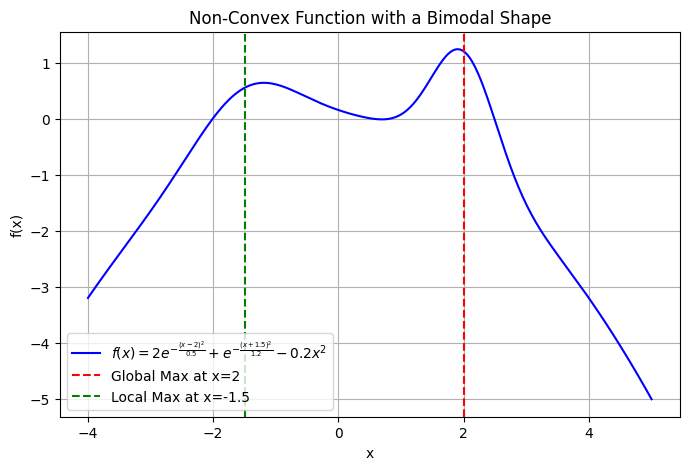

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def bimodal_function(x):
    return 2 * np.exp(- (x - 2)**2 / 0.5) + np.exp(- (x + 1.5)**2 / 1.2) - 0.2 * x**2

# Generate x values
x = np.linspace(-4, 5, 400)
y = bimodal_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label=r'$f(x) = 2 e^{-\frac{(x - 2)^2}{0.5}} + e^{-\frac{(x + 1.5)^2}{1.2}} - 0.2x^2$', color='b')
plt.axvline(x=2, linestyle='--', color='r', label="Global Max at x=2")
plt.axvline(x=-1.5, linestyle='--', color='g', label="Local Max at x=-1.5")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Non-Convex Function with a Bimodal Shape")
plt.grid()
plt.show()


In [ ]:
def bimodal_function(x):
    return 2 * np.exp(- (x - 2)**2 / 0.5) + np.exp(- (x + 1.5)**2 / 1.2) - 0.2 * x**2

x = np.linspace(-4, 5, 400)
y = bimodal_function(x)

np.min(y), np.max(y)

(np.float64(-4.99999996954004), np.float64(1.2383153328607603))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the bimodal function
def bimodal_function(x):
    return 2 * torch.exp(- (x - 2)**2 / 0.5) + torch.exp(- (x + 1.5)**2 / 1.2) - 0.2 * x**2

# Try multiple starting points
num_trials = 10
best_x = None
best_y = float('-inf')

for trial in range(num_trials):
    # Initialize x randomly in the range [-4, 5]
    x = torch.tensor([np.random.uniform(-4, 5)], requires_grad=True)
    optimizer = optim.Adam([x], lr=0.1)

    # Training loop
    num_iterations = 100
    for i in range(num_iterations):
        optimizer.zero_grad()
        y = bimodal_function(x)
        (-y).backward()
        optimizer.step()

        # Clamp x within a reasonable range to prevent instability
        x.data.clamp_(-4, 5)

    # Store the best result
    if y.item() > best_y:
        best_y = y.item()
        best_x = x.item()

    print(f"Trial {trial+1}: x = {x.item():.4f}, f(x) = {y.item():.4f}")

# Final result
print("\nEstimated global maximum:")
print(f"x = {best_x:.4f}, f(x) = {best_y:.4f}")


Trial 1: x = 1.9030, f(x) = 1.2385
Trial 2: x = 1.8982, f(x) = 1.2382
Trial 3: x = 1.9015, f(x) = 1.2385
Trial 4: x = -1.1917, f(x) = 0.6398
Trial 5: x = 1.9021, f(x) = 1.2385
Trial 6: x = -1.1890, f(x) = 0.6398
Trial 7: x = -1.1966, f(x) = 0.6398
Trial 8: x = 1.9017, f(x) = 1.2385
Trial 9: x = 1.9012, f(x) = 1.2385
Trial 10: x = 1.9024, f(x) = 1.2385

Estimated global maximum:
x = 1.9015, f(x) = 1.2385


array([[158, 177, 155, ..., 156, 153, 157],
       [117, 144, 139, ..., 155, 155, 157],
       [165, 174, 177, ..., 154, 154, 154],
       ...,
       [125, 166, 202, ..., 219, 216, 221],
       [ 65,  70, 167, ..., 214, 206, 210],
       [102, 146, 199, ..., 202, 205, 187]], dtype=uint8)
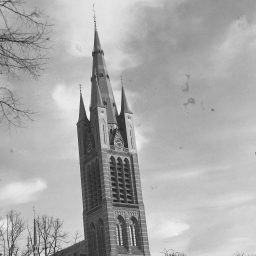

In [ ]:
img

Best sigma's MSE: 687270.187500
Trial 1: sigma=2.4001, MSE=7353.587402
Trial 2: sigma=0.9836, MSE=29112.398438
Trial 3: sigma=1.7786, MSE=7838.679688
Trial 4: sigma=0.5281, MSE=905.050842
Trial 5: sigma=2.4001, MSE=7353.583984
Trial 6: sigma=8.2488, MSE=7265.969238
Trial 7: sigma=3.2238, MSE=7243.816895
Trial 8: sigma=1.2743, MSE=11073.333984
Trial 9: sigma=2.4001, MSE=7353.583008
Trial 10: sigma=3.2238, MSE=7243.820801
Trial 11: sigma=3.2238, MSE=7243.834961
Trial 12: sigma=0.6008, MSE=929.097900
Trial 13: sigma=8.2478, MSE=7265.967285
Trial 14: sigma=3.2238, MSE=7243.832031
Trial 15: sigma=0.2422, MSE=877.872437
Trial 16: sigma=8.1276, MSE=7267.428711
Trial 17: sigma=0.5335, MSE=906.346436
Trial 18: sigma=1.6165, MSE=8329.011719
Trial 19: sigma=1.4988, MSE=8874.746094
Trial 20: sigma=3.2238, MSE=7243.817871


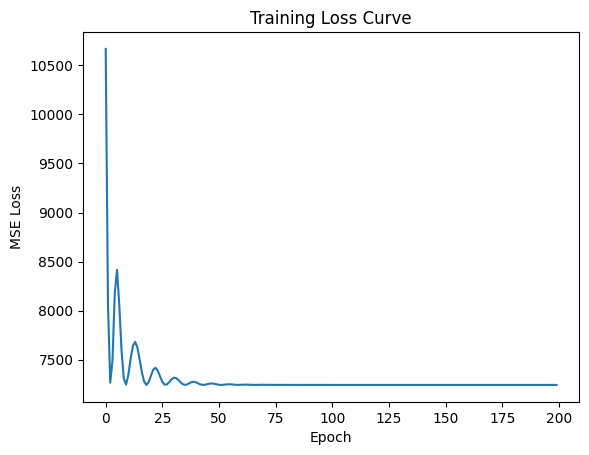

Optimal sigma found: 0.2422


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

global_results = []

# Gaussian Kernel Function
def gaussian_kernel(sigma):
    grid = torch.tensor([
        [1**2 + 1**2, 0**2 + 1**2, 1**2 + 1**2],
        [1**2 + 0**2, 0**2 + 0**2, 1**2 + 0**2],
        [1**2 + 1**2, 0**2 + 1**2, 1**2 + 1**1]
    ], dtype=torch.float32)

    k = torch.exp(-grid / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    k /= k.sum()  # Normalize
    return k

def deconvolve_image(img, sigma_t, eps=1e-6):
    k_t = gaussian_kernel(sigma_t)

    fft_shape = img.shape
    y_fft = torch.fft.fft2(img)
    k_fft = torch.fft.fft2(k_t, s=fft_shape)

    # Regularized Deconvolution
    x_recovered_fft = (y_fft * torch.conj(k_fft)) / (torch.abs(k_fft) ** 2 + eps)
    x_recovered = torch.fft.ifft2(x_recovered_fft).real
    x_recovered = x_recovered[:img.shape[0], :img.shape[1]]

    mse = torch.mean((original_img - x_recovered) ** 2)
    return mse, x_recovered

# "Neural Network" with Log-Sigma Parameterization
class SigmaNet(nn.Module):
    def __init__(self):
        super(SigmaNet, self).__init__()
        # Randomize sigma between 0.5 and 5.0
        sigma_init = np.random.uniform(0.5, 5.0)
        self.log_sigma = nn.Parameter(torch.tensor(np.log(sigma_init), requires_grad=True))

    def forward(self, img):
        sigma = torch.exp(self.log_sigma)  # Ensure sigma > 0
        mse, _ = deconvolve_image(img, sigma)
        global_results.append((sigma, mse.item()))
        return mse

# Convert image to PyTorch tensor
original_img = torch.tensor(img, dtype=torch.float32)
sigma_true = 3  # True sigma used for blurring
k = gaussian_kernel(torch.tensor(sigma_true, dtype=torch.float32))
blurred_img = convolve2d(original_img.numpy(), k.numpy(), mode='same')
blurred_img = torch.tensor(blurred_img, dtype=torch.float32)

# best sigma's mse
mse_best, _ = deconvolve_image(original_img, sigma_true)
print(f"Best sigma's MSE: {mse_best:.6f}")

# Multiple trials to avoid local minima
num_trials = 20
best_sigma = None
best_loss = float('inf')

for trial in range(num_trials):
    model = SigmaNet()
    optimizer = optim.Adam(model.parameters(), lr=0.05)  # Use Adam
    losses = []

    epochs = 200
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = model(blurred_img)
        loss.backward()
        optimizer.step()

        # Convert log_sigma to sigma for display
        sigma_value = torch.exp(model.log_sigma).item()

        losses.append(loss.item())

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_sigma = torch.exp(model.log_sigma).item()

    print(f"Trial {trial+1}: sigma={sigma_value:.4f}, MSE={loss.item():.6f}")

# Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve")
plt.show()

print(f"Optimal sigma found: {best_sigma:.4f}")


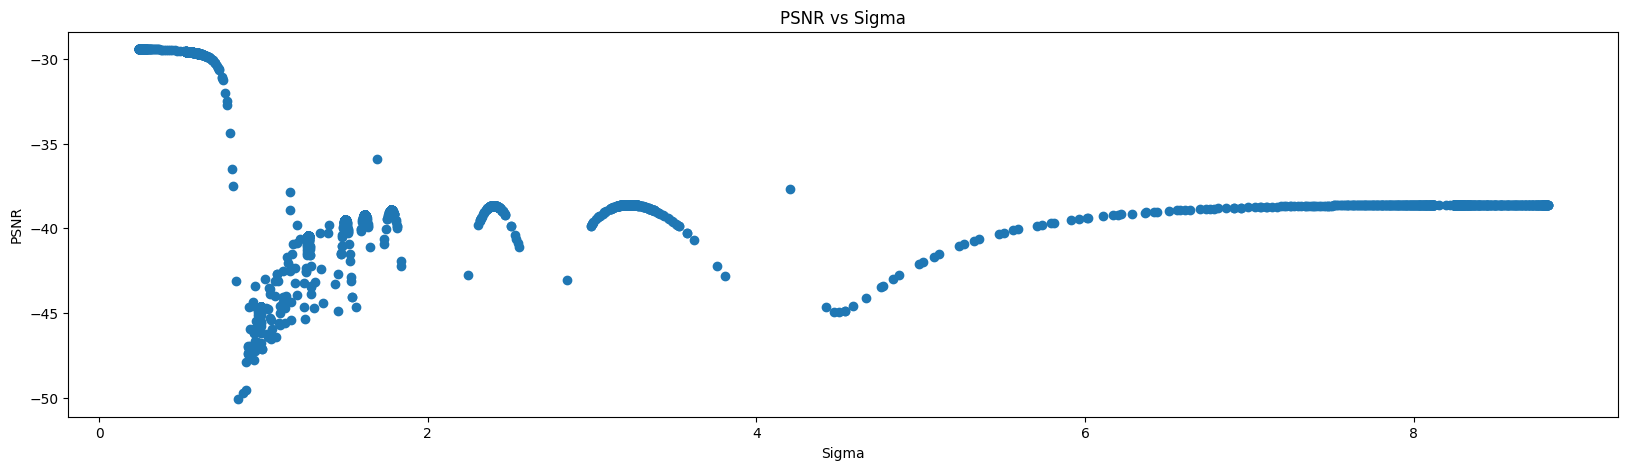

In [ ]:
# plot the sigma and psnr

sigmas = [x[0].detach().numpy() for x in global_results]
mse = [x[1] for x in global_results]
psnr = [10 * np.log10(1 / x) for x in mse]

plt.figure(figsize=(20, 5))
plt.scatter(sigmas, psnr)
plt.xlabel("Sigma")
plt.ylabel("PSNR")
plt.title("PSNR vs Sigma")

plt.show()

PSNR: -31.863573


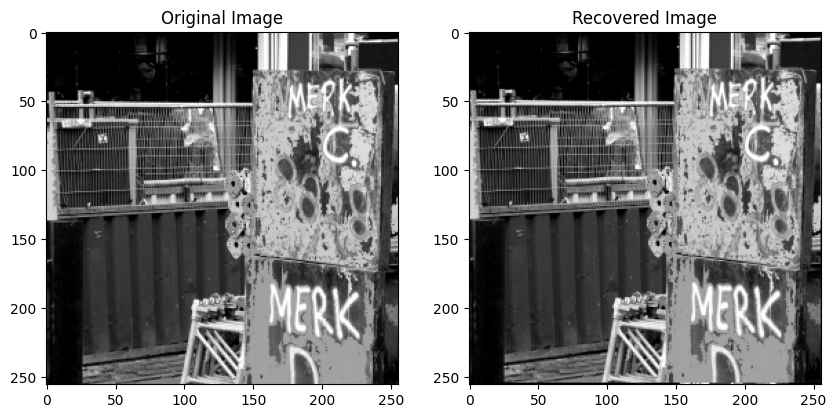

In [ ]:
original_img = torch.tensor(img, dtype=torch.float32)

mse, X_recovered = deconvolve_image(original_img, 0.2147)

# Ensure both tensors are NumPy arrays before computing PSNR
original_np = original_img.numpy()
recovered_np = X_recovered.numpy()

mse = np.mean((original_np - recovered_np) ** 2)
psnr = 10 * np.log10(1 / mse)  # Assuming pixel values are normalized [0,1]

print(f"PSNR: {psnr:.6f}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_np, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(recovered_np, cmap='gray')
plt.title("Recovered Image")

plt.show()

# Lucy Richardson with neural network

In [5]:
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=50):
    """
    Perform Richardson-Lucy blind deconvolution to estimate both x and k.

    Parameters:
    y : np.array
        Blurred image
    k_init : np.array
        Initial guess for the blur kernel
    num_iter : int
        Number of iterations to run

    Returns:
    x_est : np.array
        Estimated sharp image
    k_est : np.array
        Estimated blur kernel
    """
    x_est = np.copy(y)  # Initialize x as y
    k_est = np.copy(k_init)  # Initial kernel guess

    for i in range(num_iter):
        # Compute blurred estimate of x
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_x = y / (x_blurred + 1e-8)
        x_est *= convolve2d(relative_blur_x, k_est[::-1, ::-1], mode='same', boundary='wrap')

        # Compute blurred estimate of k
        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        relative_blur_k = y / (k_blurred + 1e-8)
        k_update = convolve2d(x_est[::-1, ::-1], relative_blur_k, mode='valid', boundary='wrap')

        # Normalize the kernel to sum to 1
        k_est *= k_update
        k_est /= np.sum(k_est)

    return x_est, k_est

def evaluate(num_iter):
    # Define Gaussian blur kernel
    sigma = 2
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
    ]) / (2 * np.pi * sigma**2)
    k /= k.sum()

    # Load an example image (grayscale 256x256)
    x = img  # Assuming 'img' is a 256x256 image

    # Generate blurred image
    y = convolve2d(x, k, mode='same', boundary='wrap')

    # Initialize the kernel estimate
    # k_init = np.ones_like(k) / np.sum(k)
    k_init = np.abs(np.random.rand(*k.shape))  # Generate random values
    k_init /= np.sum(k_init)  # Normalize to sum to 1


    # Perform blind deconvolution
    x_recovered, k_recovered = richardson_lucy_blind_deconvolution(y, k_init, num_iter)

    # PSNR
    mse_recovery = np.mean((x - x_recovered) ** 2)
    max_val = np.max(x)
    psnr_recovery = 10 * np.log10(max_val**2 / mse_recovery)

    print("Recovered x from frequency domain:", np.round(x_recovered))
    print("MSE between original and recovered x:", mse_recovery)
    print("PSNR between original and recovered x:", psnr_recovery)

    # Display results
    plt.figure(figsize=(20, 10))
    plt.subplot(131), plt.imshow(x, cmap='gray'), plt.title("Original Image")
    plt.subplot(132), plt.imshow(y, cmap='gray'), plt.title("Blurred Image")
    plt.subplot(133), plt.imshow(x_recovered, cmap='gray'), plt.title("Recovered Image")
    plt.show()

    print("Recovered Kernel:")
    print(k_recovered)

iters = [5, 20, 100, 1000, 5000, 10000]
for num_iter in iters:
    evaluate(num_iter)

Output hidden; open in https://colab.research.google.com to view.

Generating training data...
Generating blurred image with sigma=0.5
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=0.5: -34.1777
Generating blurred image with sigma=1.0
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=1.0: -23.3651
Generating blurred image with sigma=1.5
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=1.5: -18.9968
Generating blurred image with sigma=2.0
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=2.0: -17.6215
Generating blurred image with sigma=2.5
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=2.5: -17.1686
Generating blurred image with sigma=3.0
Starting Richardson-Lucy deconvolution...
Iteration 0/100
Deconvolution complete.
PSNR for sigma=3.0: -16.9951
Generating blurred image with sigma=3.5
Starting Richardson-Lucy d

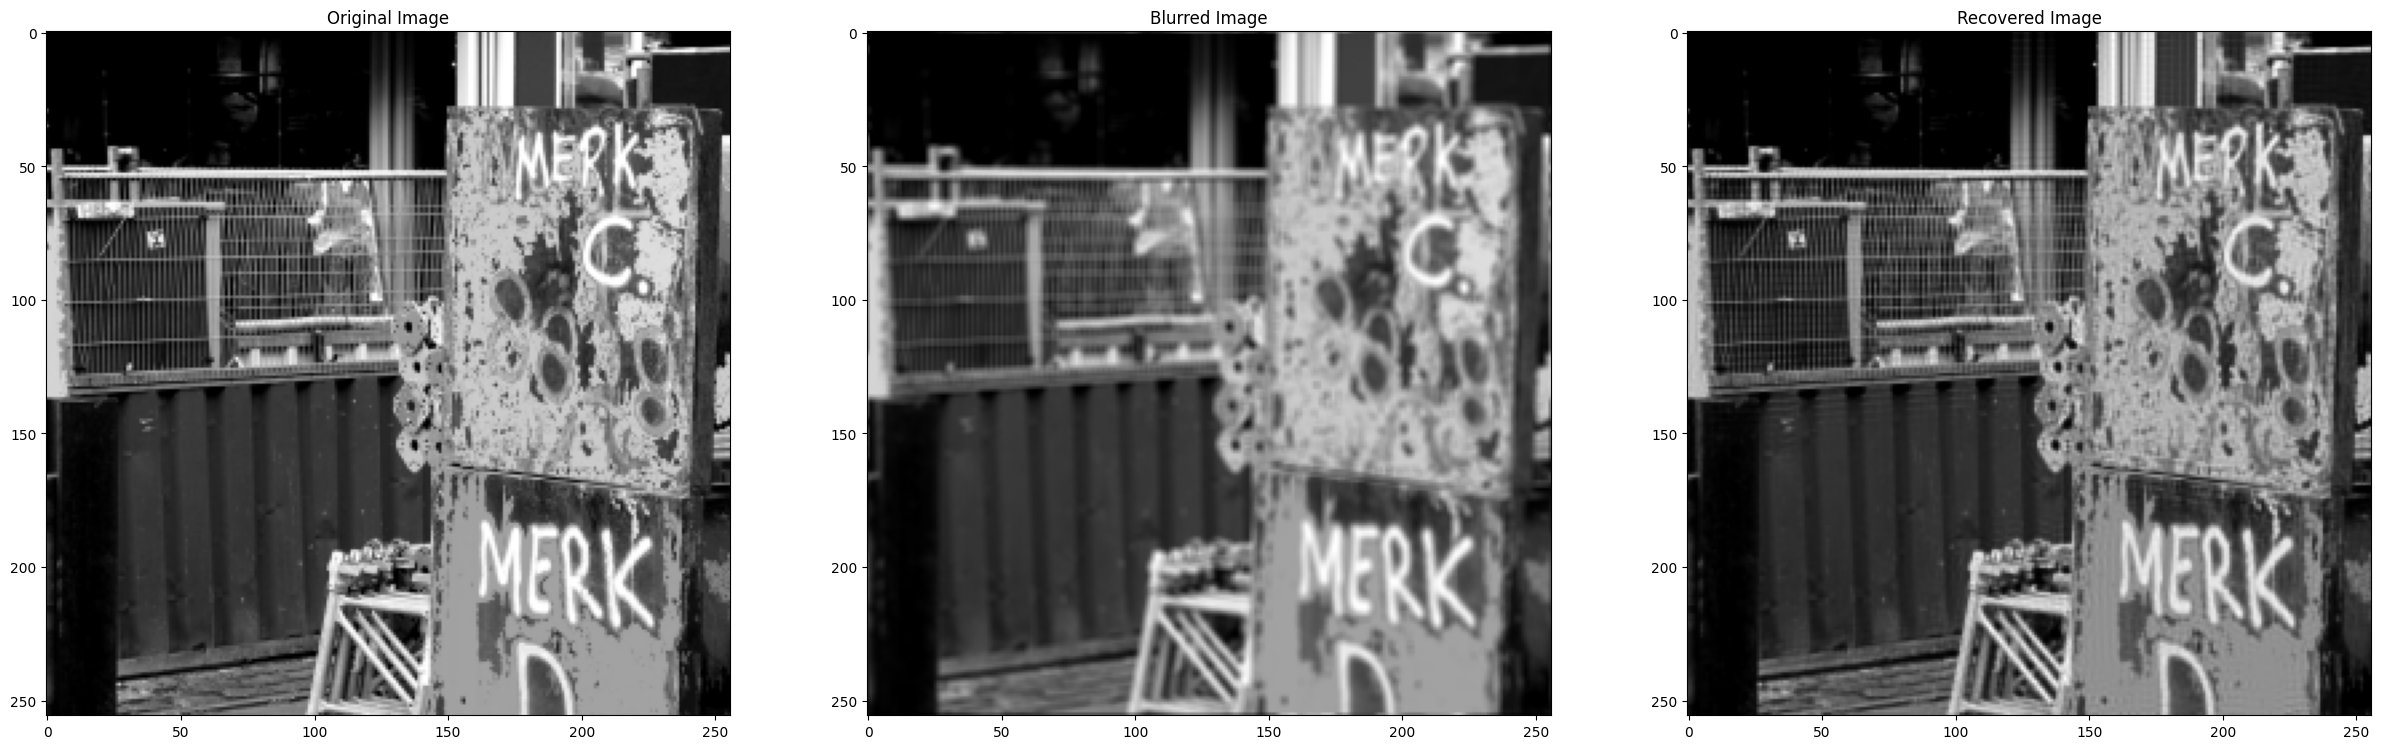

In [ ]:
import numpy as np
import torch
from scipy.signal import convolve2d
from torch import nn, optim


def richardson_lucy_blind_deconvolution(y, k_init, num_iter=100):
    print("Starting Richardson-Lucy deconvolution...")
    x_est = np.copy(y)
    k_est = np.copy(k_init)

    for i in range(num_iter):
        if i % 100 == 0:
            print(f"Iteration {i}/{num_iter}")
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        x_est *= convolve2d(y / (x_blurred + 1e-8), k_est[::-1, ::-1], mode='same', boundary='wrap')

        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        k_update = convolve2d(x_est[::-1, ::-1], y / (k_blurred + 1e-8), mode='valid', boundary='wrap')
        k_est *= k_update
        k_est /= np.sum(k_est)

    print("Deconvolution complete.")
    return x_est, k_est


def generate_blurred_data(img, sigma):
    print(f"Generating blurred image with sigma={sigma}")
    k = np.array([
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**1) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
        [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
    ]) / (2 * np.pi * sigma**2)
    k /= k.sum()
    y = convolve2d(img, k, mode='same', boundary='wrap')
    return y, k


def psnr(original, recovered):
    mse = np.mean((original - recovered) ** 2)
    max_val = np.max(original)
    return 10 * np.log10(max_val**2 / mse)


class SigmaPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.fc(x)


def train_nn(train_data, train_labels, num_epochs=50):
    print("Starting neural network training...")
    model = SigmaPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(num_epochs):
        inputs = torch.tensor(train_data, dtype=torch.float32).view(-1, 1)
        targets = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.6f}")

    print("Training complete.")
    return model


print("Generating training data...")
train_sigmas = np.linspace(0.5, 5.0, 10)
train_data, train_labels = [], []
for sigma in train_sigmas:
    y, _ = generate_blurred_data(img, sigma)
    x_recovered, _ = richardson_lucy_blind_deconvolution(y, np.ones((3,3)) / 9, num_iter=100)
    psnr_value = psnr(img, x_recovered)
    print(f"PSNR for sigma={sigma}: {psnr_value:.4f}")
    train_data.append([psnr_value])
    train_labels.append(sigma)

nn_model = train_nn(train_data, train_labels)

test_img = img  # Replace with actual test image
y_test, _ = generate_blurred_data(test_img, sigma=3.0)  # Testing with sigma=3
x_test_recovered, _ = richardson_lucy_blind_deconvolution(y_test, np.ones((3,3)) / 9, num_iter=100)
psnr_test = psnr(test_img, x_test_recovered)
predicted_sigma = nn_model(torch.tensor([[psnr_test]], dtype=torch.float32)).item()

print(f"Predicted sigma: {predicted_sigma:.4f}")

# plot the test recovery
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(test_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test, cmap='gray')
plt.title("Blurred Image")

plt.subplot(1, 3, 3)
plt.imshow(x_test_recovered, cmap='gray')
plt.title("Recovered Image")

plt.show()

Best sigma's MSE: 687270.187500
Optimal sigma found: 0.6813
Optimal sigma's MSE: 1000.797852


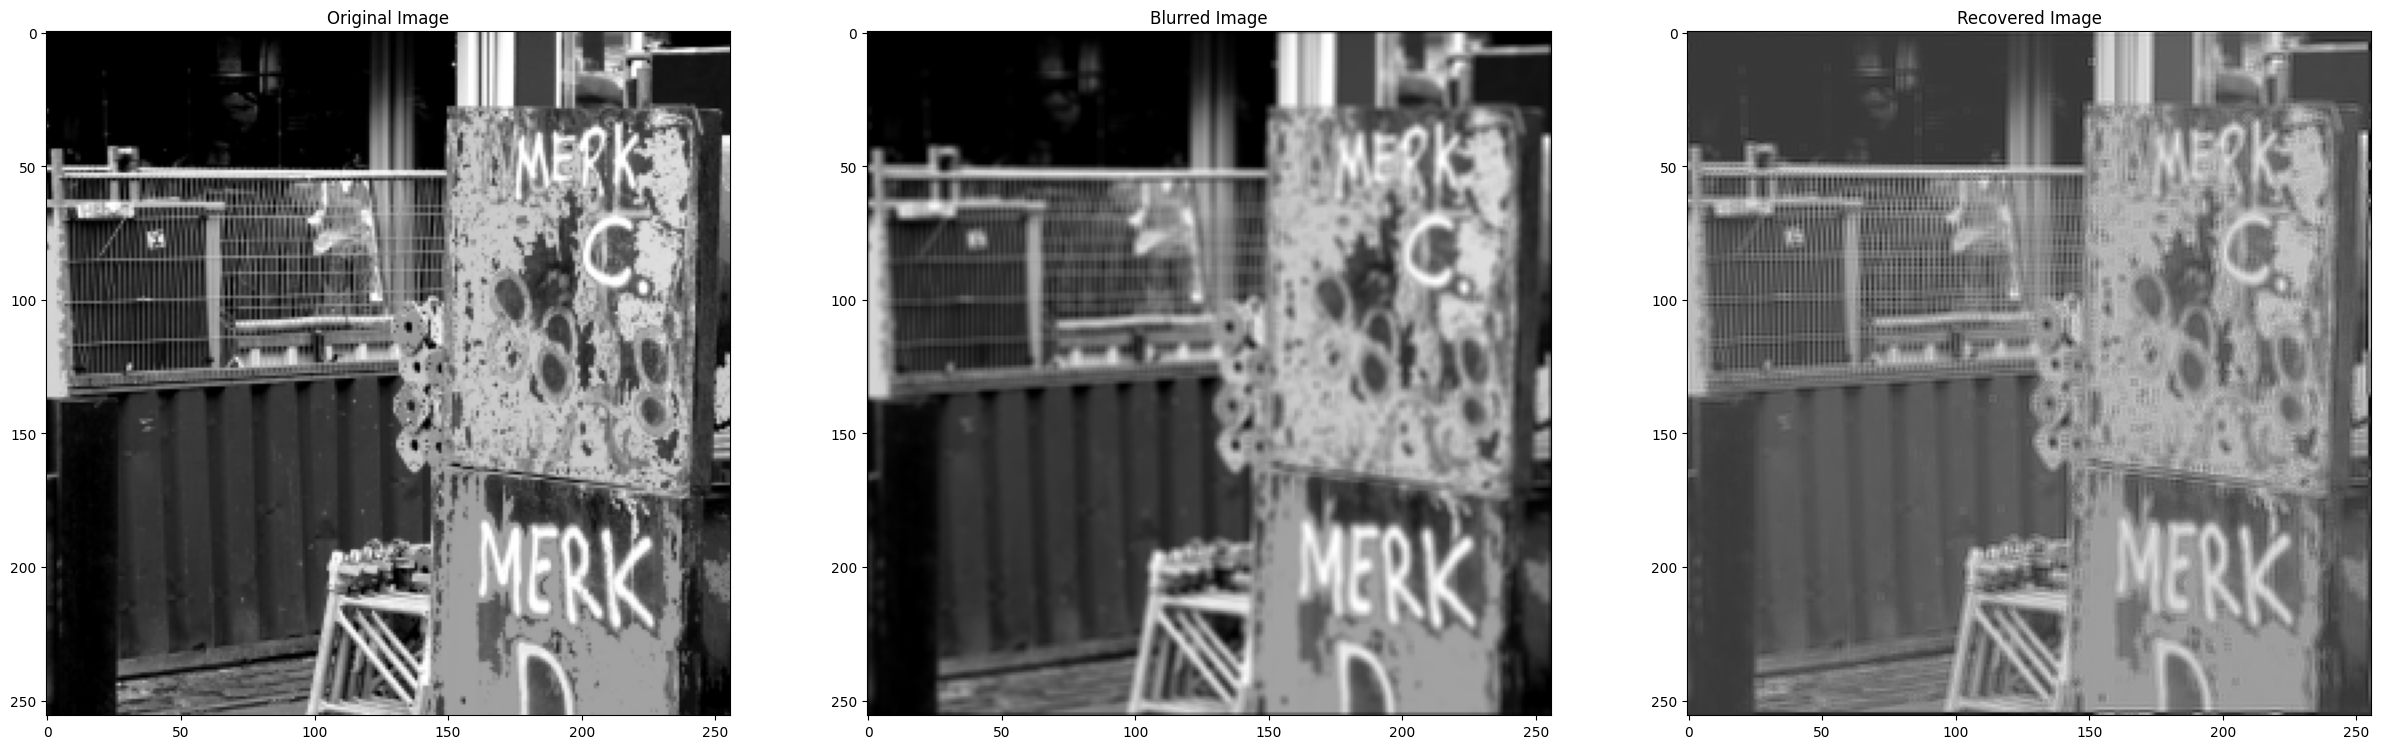

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import convolve2d

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=100):
    x_est = np.copy(y)
    k_est = np.copy(k_init)
    for _ in range(num_iter):
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        x_est *= convolve2d(y / (x_blurred + 1e-8), k_est[::-1, ::-1], mode='same', boundary='wrap')
        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        k_update = convolve2d(x_est[::-1, ::-1], y / (k_blurred + 1e-8), mode='valid', boundary='wrap')
        k_est *= k_update
        k_est /= np.sum(k_est)
    return x_est, k_est

def gaussian_kernel(sigma):
    grid = torch.tensor([[2, 1, 2], [1, 0, 1], [2, 1, 2]], dtype=torch.float32)
    k = torch.exp(-grid / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return k / k.sum()

def deconvolve_image(img, sigma_t, eps=1e-6):
    k_t = gaussian_kernel(sigma_t)
    fft_shape = img.shape
    y_fft = torch.fft.fft2(img)
    k_fft = torch.fft.fft2(k_t, s=fft_shape)
    x_recovered_fft = (y_fft * torch.conj(k_fft)) / (torch.abs(k_fft) ** 2 + eps)
    x_recovered = torch.fft.ifft2(x_recovered_fft).real[:img.shape[0], :img.shape[1]]
    return torch.mean((original_img - x_recovered) ** 2), x_recovered

class SigmaNet(nn.Module):
    def __init__(self):
        super(SigmaNet, self).__init__()
        self.log_sigma = nn.Parameter(torch.tensor(np.log(np.random.uniform(0.5, 5.0)), requires_grad=True))
    def forward(self, img):
        return deconvolve_image(img, torch.exp(self.log_sigma))[0]

original_img = torch.tensor(img, dtype=torch.float32)
sigma_true = 3
k = gaussian_kernel(torch.tensor(sigma_true, dtype=torch.float32))
blurred_img = torch.tensor(convolve2d(original_img.numpy(), k.numpy(), mode='same'), dtype=torch.float32)

mse_best, _ = deconvolve_image(original_img, sigma_true)
print(f"Best sigma's MSE: {mse_best:.6f}")

num_trials, best_sigma, best_loss = 20, None, float('inf')
for _ in range(num_trials):
    model, optimizer = SigmaNet(), optim.Adam(model.parameters(), lr=0.05)
    for _ in range(200):
        optimizer.zero_grad()
        loss = model(blurred_img)
        loss.backward()
        optimizer.step()
    if loss.item() < best_loss:
        best_loss, best_sigma = loss.item(), torch.exp(model.log_sigma).item()
print(f"Optimal sigma found: {best_sigma:.4f}")

mse_optimal, x_test_recovered = deconvolve_image(blurred_img, best_sigma)
print(f"Optimal sigma's MSE: {mse_optimal:.6f}")

# plot the test recovery
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(blurred_img, cmap='gray')
plt.title("Blurred Image")

plt.subplot(1, 3, 3)
plt.imshow(x_test_recovered, cmap='gray')
plt.title("Recovered Image")

plt.show()

In [ ]:
!wget "https://live.staticflickr.com/163/433449690_064840297c.jpg" -O image_new.jpg

--2025-03-20 15:23:40--  https://live.staticflickr.com/163/433449690_064840297c.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 108.156.94.80, 2600:9000:2163:b400:0:5a51:64c9:c681, 2600:9000:2163:ca00:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|108.156.94.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image_new.jpg’

image_new.jpg           [ <=>                ]  70.77K  --.-KB/s    in 0.02s   

2025-03-20 15:23:40 (3.01 MB/s) - ‘image_new.jpg’ saved [72473]



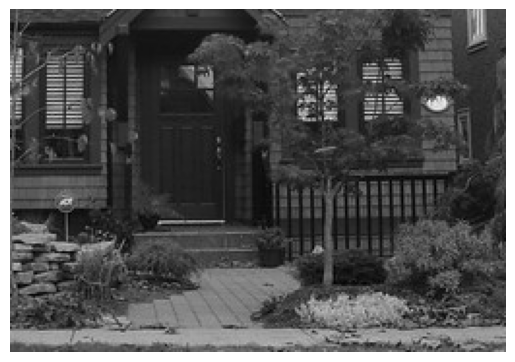

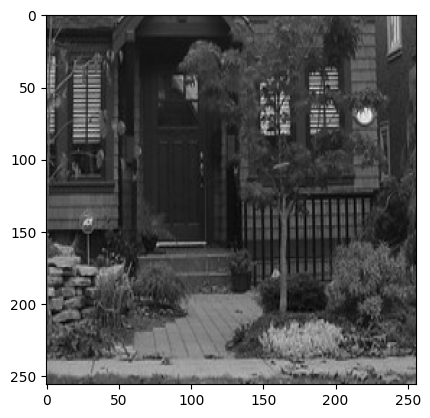

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img_new = cv2.imread('image_new.jpg', cv2.IMREAD_GRAYSCALE)

# Define cropping coordinates
x, y, w, h = 100, 220, 256, 256
img_new = img_new[y:y+h, x:x+w]

# Show cropped image
plt.imshow(img_new, cmap='gray')
plt.axis('off')
plt.show()

# Resize image to 256x256
img_new = cv2.resize(img_new, (256, 256), interpolation=cv2.INTER_AREA)

# Show resized image
plt.imshow(img_new, cmap='gray')
plt.show()



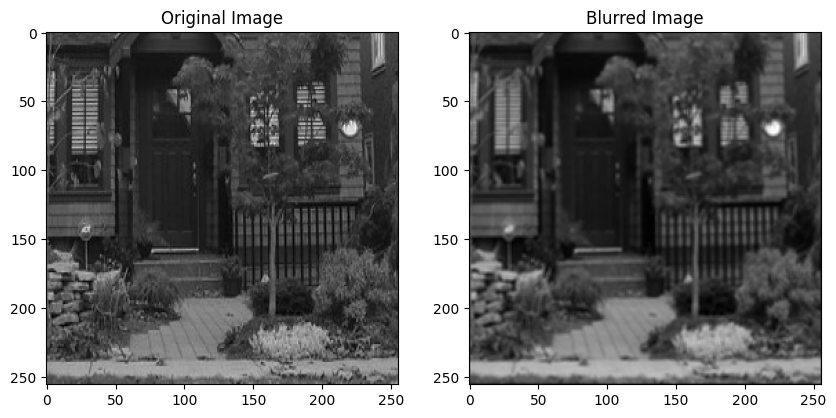

In [ ]:
original_img = torch.tensor(img_new, dtype=torch.float32)
sigma_true = 5.5
k = gaussian_kernel(torch.tensor(sigma_true, dtype=torch.float32))
blurred_img_new = torch.tensor(convolve2d(original_img.numpy(), k.numpy(), mode='same'), dtype=torch.float32)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(blurred_img_new, cmap='gray')
plt.title("Blurred Image")

plt.show()

MSE: 7701.285156
PSNR: -38.865631


<ipython-input-44-33bcf8b9fbb8>:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(f"PSNR: {10 * np.log10(1 / mse):.6f}")


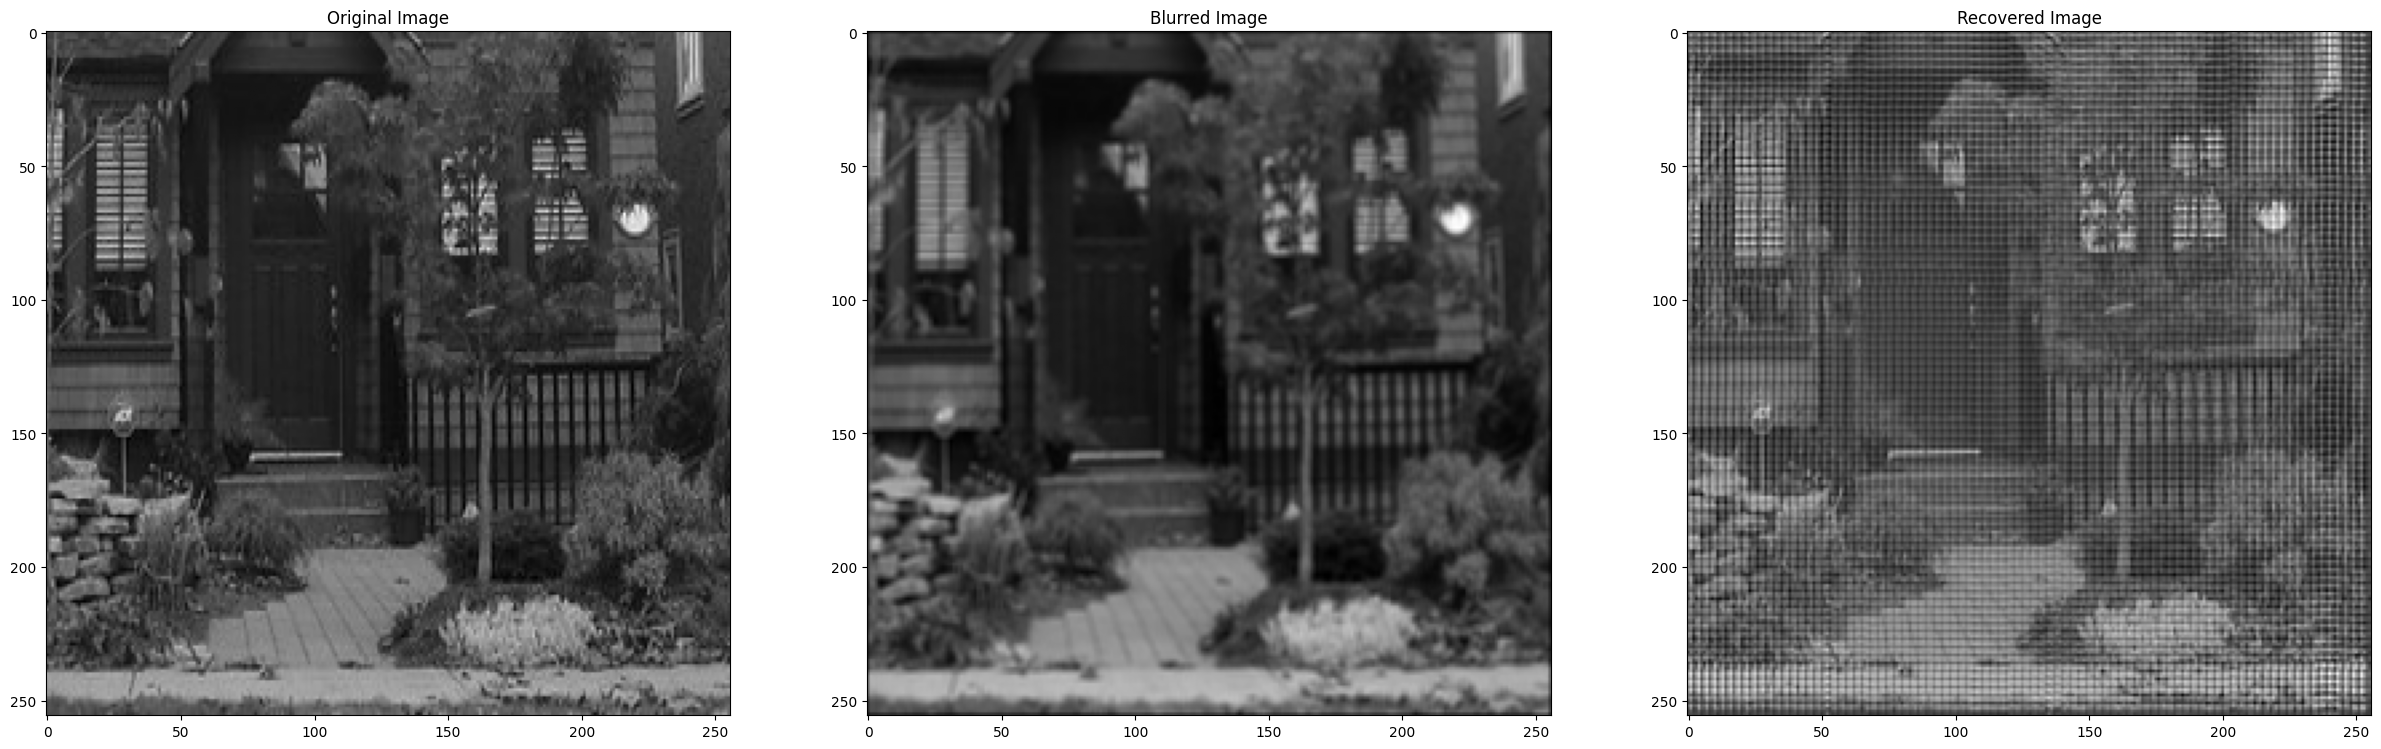

In [ ]:
mse, x_recovered = deconvolve_image(blurred_img_new, 5.5, eps=0.00005)
print(f"MSE: {mse:.6f}")
print(f"PSNR: {10 * np.log10(1 / mse):.6f}")

# plot the test recovery
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.imshow(img_new, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(blurred_img_new, cmap='gray')
plt.title("Blurred Image")

plt.subplot(1, 3, 3)
plt.imshow(x_recovered, cmap='gray')
plt.title("Recovered Image")


plt.show()

Optimal sigma found: 0.6564
Optimal sigma's MSE: 6801.762207


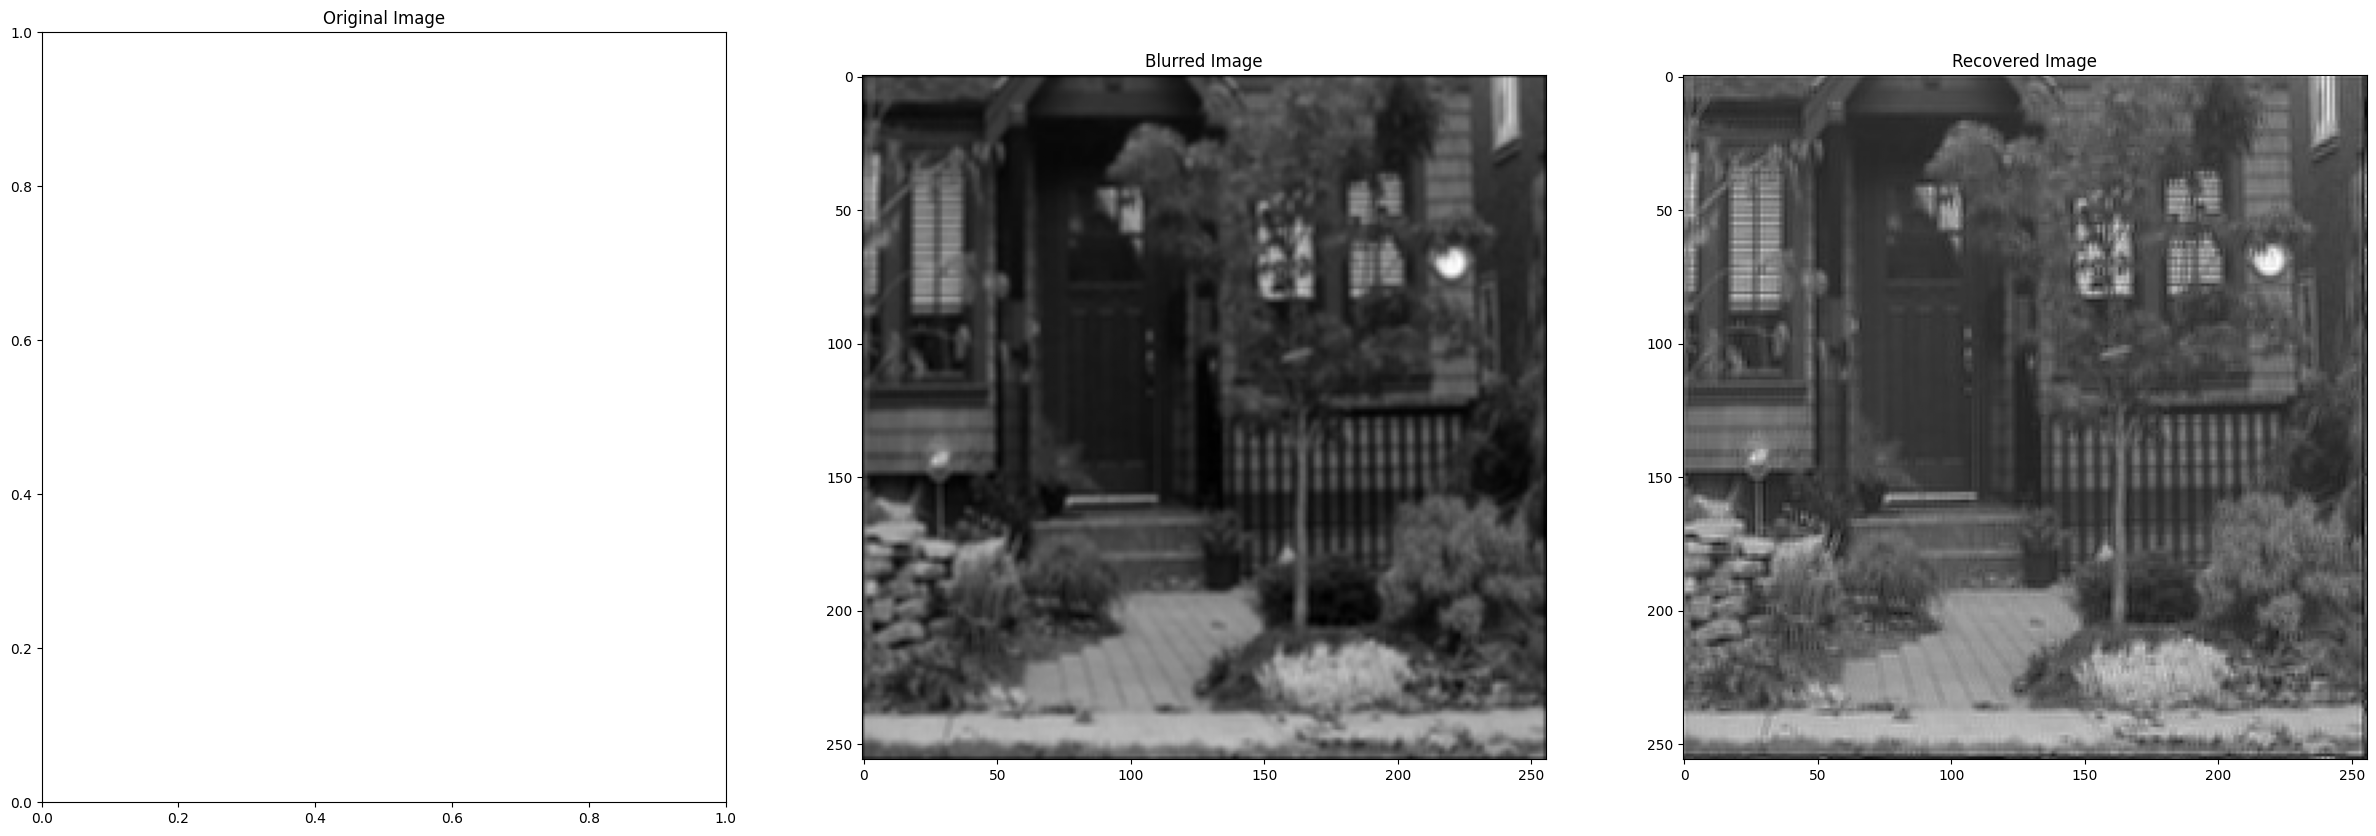

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import convolve2d

def richardson_lucy_blind_deconvolution(y, k_init, num_iter=100):
    x_est = np.copy(y)
    k_est = np.copy(k_init)
    for _ in range(num_iter):
        x_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        x_est *= convolve2d(y / (x_blurred + 1e-8), k_est[::-1, ::-1], mode='same', boundary='wrap')
        k_blurred = convolve2d(x_est, k_est, mode='same', boundary='wrap')
        k_update = convolve2d(x_est[::-1, ::-1], y / (k_blurred + 1e-8), mode='valid', boundary='wrap')
        k_est *= k_update
        k_est /= np.sum(k_est)
    return x_est, k_est

def gaussian_kernel(sigma):
    grid = torch.tensor([[2, 1, 2], [1, 0, 1], [2, 1, 2]], dtype=torch.float32)
    k = torch.exp(-grid / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return k / k.sum()

def deconvolve_image(img, sigma_t, eps=1e-6):
    k_t = gaussian_kernel(sigma_t)
    fft_shape = img.shape
    y_fft = torch.fft.fft2(img)
    k_fft = torch.fft.fft2(k_t, s=fft_shape)
    x_recovered_fft = (y_fft * torch.conj(k_fft)) / (torch.abs(k_fft) ** 2 + eps)
    x_recovered = torch.fft.ifft2(x_recovered_fft).real[:img.shape[0], :img.shape[1]]
    return torch.mean((original_img - x_recovered) ** 2), x_recovered

class SigmaNet(nn.Module):
    def __init__(self):
        super(SigmaNet, self).__init__()
        self.log_sigma = nn.Parameter(torch.tensor(np.log(np.random.uniform(0.5, 5.0)), requires_grad=True))
    def forward(self, img):
        return deconvolve_image(img, torch.exp(self.log_sigma))[0]

# original_img = torch.tensor(img, dtype=torch.float32)
# sigma_true = 3
# k = gaussian_kernel(torch.tensor(sigma_true, dtype=torch.float32))
# blurred_img = torch.tensor(convolve2d(original_img.numpy(), k.numpy(), mode='same'), dtype=torch.float32)
blurred_img = blurred_img_new

# mse_best, _ = deconvolve_image(original_img, sigma_true)
# print(f"Best sigma's MSE: {mse_best:.6f}")

num_trials, best_sigma, best_loss = 20, None, float('inf')
for _ in range(num_trials):
    model, optimizer = SigmaNet(), optim.Adam(model.parameters(), lr=0.05)
    for _ in range(200):
        optimizer.zero_grad()
        loss = model(blurred_img)
        loss.backward()
        optimizer.step()
    if loss.item() < best_loss:
        best_loss, best_sigma = loss.item(), torch.exp(model.log_sigma).item()
print(f"Optimal sigma found: {best_sigma:.4f}")

mse_optimal, x_test_recovered = deconvolve_image(blurred_img, best_sigma)
print(f"Optimal sigma's MSE: {mse_optimal:.6f}")

# plot the test recovery
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
# plt.imshow(original_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(blurred_img, cmap='gray')
plt.title("Blurred Image")

plt.subplot(1, 3, 3)
plt.imshow(x_test_recovered, cmap='gray')
plt.title("Recovered Image")

plt.show()